In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from torch.backends import cudnn
cudnn.benchmark = True
cudnn.enabled = True

In [2]:
# load cell classification dict
from tang_jcompneuro.cell_classification import get_ready_to_use_classification
cell_class_dict = get_ready_to_use_classification()

In [3]:
# load data
# remember to scale y to make them have mean around 0.5
from tang_jcompneuro.io import load_split_dataset
datasets_all = load_split_dataset('MkA_Shape', 'all', True, slice(None), seed=0)
def scale_dataset():
    datasets_all_new = []
    for idx, x in enumerate(datasets_all):
        print(x.shape)
        if idx % 2:
            y=x*2
            print(y.shape, y.mean(axis=0))
            print(np.median(y.mean(axis=0)), y.mean(axis=0).min(), y.mean(axis=0).max())
            # looks good to me.
        else:
            y=x
        datasets_all_new.append(y)
    return tuple(datasets_all_new)
datasets_all = scale_dataset()

(6080, 1, 20, 20)
(6080, 1142)
(6080, 1142) [ 0.3305665   0.40650404  0.38186221 ...,  0.47243628  0.33701788
  0.47037201]
0.364467475667 0.177206700132 1.7273072627
(1900, 1, 20, 20)
(1900, 1142)
(1900, 1142) [ 0.33074297  0.41074199  0.38362263 ...,  0.4728108   0.3405088
  0.47498101]
0.365467919 0.177957142692 1.72359397086
(1520, 1, 20, 20)
(1520, 1142)
(1520, 1142) [ 0.32992763  0.41212338  0.38461031 ...,  0.47626194  0.3380989
  0.47011715]
0.36502551484 0.177134537388 1.71715092768


In [4]:
from tang_jcompneuro.model_fitting_postprocess import load_model_performance

In [5]:
# load b.9 performance as baseline
# let's work on OT neurons first.
neuron_subset = 'OT'
baseline_perf = load_model_performance('MkA_Shape', 'all',
                                       100, 0, 'cnn', 'b.9')['corr'][cell_class_dict['MkA_Shape'][neuron_subset]]
print(baseline_perf.shape, (baseline_perf**2).mean())

(427,) 0.296250691538


In [6]:
# trim datasets_all
def trim_dataset():
    datasets_all_new = []
    for idx, x in enumerate(datasets_all):
        print(x.shape)
        if idx % 2:
            y=x[:, cell_class_dict['MkA_Shape'][neuron_subset]]
        else:
            y=x
        datasets_all_new.append(y)
    return tuple(datasets_all_new)
datasets = trim_dataset()

(6080, 1, 20, 20)
(6080, 1142)
(1900, 1, 20, 20)
(1900, 1142)
(1520, 1, 20, 20)
(1520, 1142)


In [7]:
# arch config
# follow https://github.com/leelabcnbc/thesis-proposal-yimeng/blob/master/results_ipynb_blocks/population_neuron_fitting/maskcnn_v1_training_113017_explore.ipynb
from maskcnn import cnn_aux
arch_config = cnn_aux.get_maskcnn_v1_arch_config(out_channel=118, kernel_size_l1=9, kernel_size_l23=3,
                                                 act_fn='softplus')
arch_config

{'act_fn': 'softplus',
 'conv': [{'bn': True,
   'bn_affine': True,
   'dilation': 1,
   'kernel_size': 9,
   'out_channel': 118,
   'padding': 0,
   'pool': None,
   'stride': 1},
  {'bn': True,
   'bn_affine': True,
   'dilation': 1,
   'kernel_size': 3,
   'out_channel': 118,
   'padding': 1,
   'pool': None,
   'stride': 1},
  {'bn': True,
   'bn_affine': True,
   'dilation': 1,
   'kernel_size': 3,
   'out_channel': 118,
   'padding': 1,
   'pool': None,
   'stride': 1}],
 'conv_last_no_act': True,
 'fc': {'dropout': None,
  'factored': True,
  'factored_constraint': 'abs',
  'mlp': None},
 'linear_output': False}

In [8]:
# optim config
# well, I will simply assume that smoothness and group is best to be 0, 
# as shown in my fitting to summer's data as well.
#
#
# so I will play with scale, kernel size (L1/L23), num channel.
# and loss type.
# that is all.
#
opt_config = cnn_aux.get_maskcnn_v1_opt_config(scale=0.0001, bn_scale_nolearning=False, smoothness=0.0,group=0.0)

In [9]:
# generate model
from tang_jcompneuro.cnn import CNN
model = CNN(arch_config,
            cnn_aux.v1_maskcnn_generator(),
            input_size=datasets[0].shape[2], n=datasets[1].shape[1],
            seed=0, mean_response=datasets[1].mean(axis=0))

model = model.cuda()
model = model.train()

In [10]:
from tang_jcompneuro.training_aux import count_params
print('multi', count_params(model))
print('single', 883*cell_class_dict['MkA_Shape'][neuron_subset].sum())

multi 373199
single 377041


In [11]:
# train
from maskcnn import training_aux
train_results = training_aux.train_one_case(model, datasets, opt_config,
                                           seed=0,eval_loss_type='mse',show_every=500)

========starting phase 1/3==========
========starting epoch 500==========
val metric
 {'loss': 0.018761892, 'corr': None, 'corr2_mean': 0.18346079}
test metric
 {'loss': 0.018700182, 'corr': None, 'corr2_mean': 0.18101051}
========done epoch 500==========
========starting epoch 1000==========
val metric
 {'loss': 0.017902512, 'corr': None, 'corr2_mean': 0.23712955}
test metric
 {'loss': 0.01794165, 'corr': None, 'corr2_mean': 0.23100382}
========done epoch 1000==========
========starting epoch 1500==========
val metric
 {'loss': 0.017508274, 'corr': None, 'corr2_mean': 0.26431599}
test metric
 {'loss': 0.017510958, 'corr': None, 'corr2_mean': 0.25949883}
========done epoch 1500==========
========starting epoch 2000==========
val metric
 {'loss': 0.015805643, 'corr': None, 'corr2_mean': 0.27820116}
test metric
 {'loss': 0.015798347, 'corr': None, 'corr2_mean': 0.27399424}
========done epoch 2000==========
========starting epoch 2500==========
val metric
 {'loss': 0.016692121, 'corr': No

In [12]:
# show corr between b.9 performance and this one.

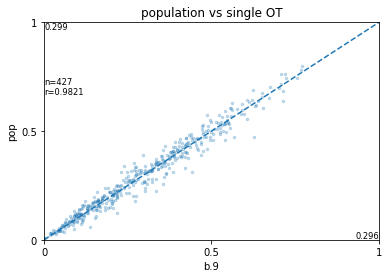

In [14]:
from tang_jcompneuro.plotting import show_one_basic
plt.close('all')
show_one_basic((baseline_perf**2), train_results[1]**2,
              xlabel='b.9', ylabel='pop', title=f'population vs single {neuron_subset}')
plt.show()